In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

In [3]:
#pick up the 1st image to have a look   
path_now = path[0]
a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))

In [10]:
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

# Here I have 14142 samples with their 
#### Obj_ID = string
#### Image = (5,64,64)
#### Class = star / galaxy
#### Redshift = redshift of the object

In [12]:
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [15]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


In [18]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=0

815


In [19]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

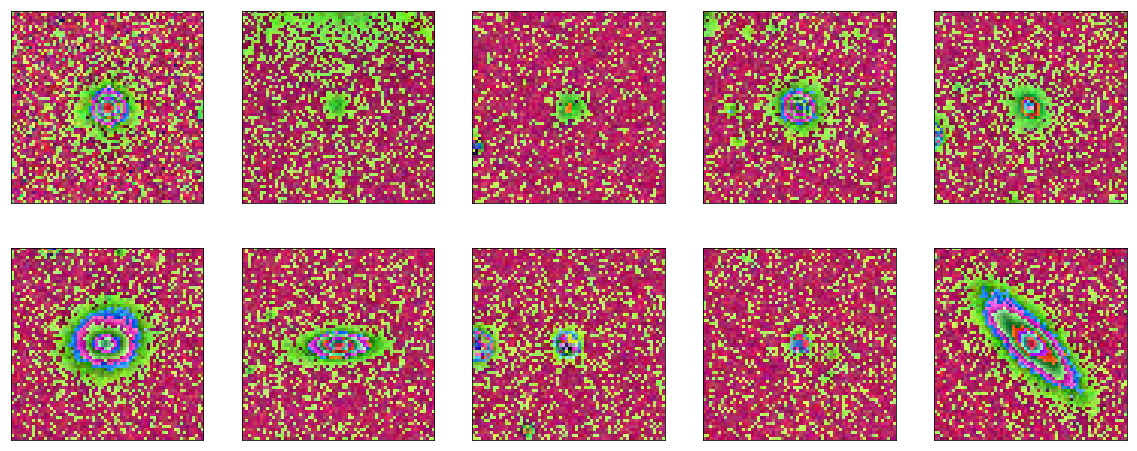

[1 1 1 1 1 1 1 0 2 1]


In [20]:
n=5
plt.figure(figsize=(20, 20*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

In [22]:
label = np_utils.to_categorical(Class, 3)

In [23]:
data = Image_RGB

In [24]:
train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
14142  samples


# Unsupervised clustering
## 1. with 3 hidden units


In [25]:
batch_size =100
latent_dim = 3
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [26]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,    
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 500 samples
Epoch 1/10
8000/8000 [==============================] - 18s - loss: -7303.1322 - val_loss: -7769.2016
Epoch 2/10
8000/8000 [==============================] - 11s - loss: -7845.0883 - val_loss: -7934.2467
Epoch 3/10
8000/8000 [==============================] - 11s - loss: -7941.3612 - val_loss: -7716.6820
Epoch 4/10
8000/8000 [==============================] - 11s - loss: -7972.5876 - val_loss: -7909.1559
Epoch 5/10
8000/8000 [==============================] - 11s - loss: -7984.9109 - val_loss: -7992.5686
Epoch 6/10
8000/8000 [==============================] - 11s - loss: -8001.9251 - val_loss: -7960.6436
Epoch 7/10
8000/8000 [==============================] - 11s - loss: -8027.1462 - val_loss: -7941.2562
Epoch 8/10
8000/8000 [==============================] - 11s - loss: -8037.9269 - val_loss: -7999.8332
Epoch 9/10
8000/8000 [==============================] - 11s - loss: -8037.8605 - val_loss: -7984.0803
Epoch 10/10
8000/8000 [============

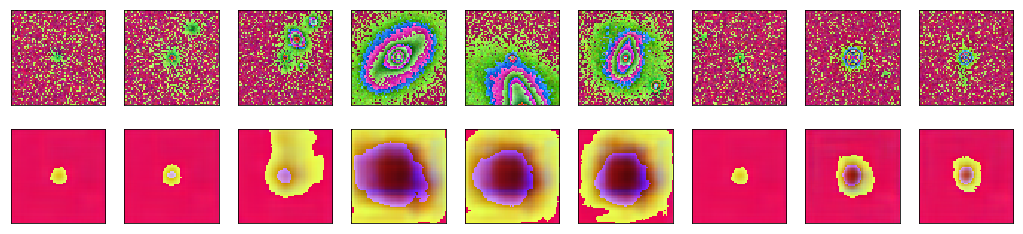

In [94]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
test_data = train_data[8500:14000]
#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(test_data,batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(test_data,batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((test_data[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

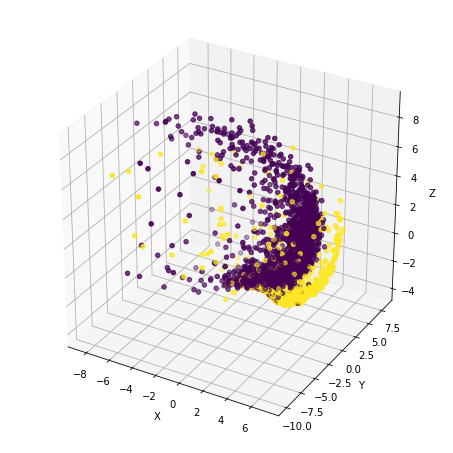

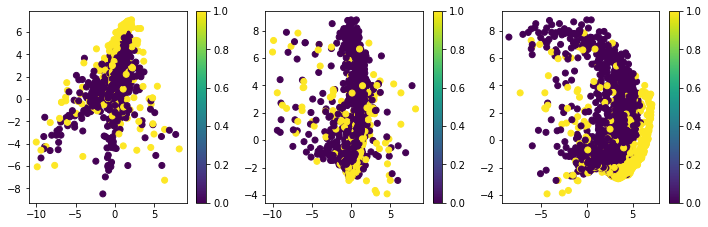

In [95]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(test_data, batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=label_value[8500:14000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000])
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000])
plt.colorbar()
plt.show()

## Left: vertical view ;            Mid: front view;               Right: side view
## Clustering (with sklearn, and its clustering algorithms: LLE, ISOMAP...)

Automatically created module for IPython interactive environment
standard: 0.81 sec
modified: 1.6 sec
Isomap: 14 sec
MDS: 93 sec
SpectralEmbedding: 1.3 sec
t-SNE: 75 sec


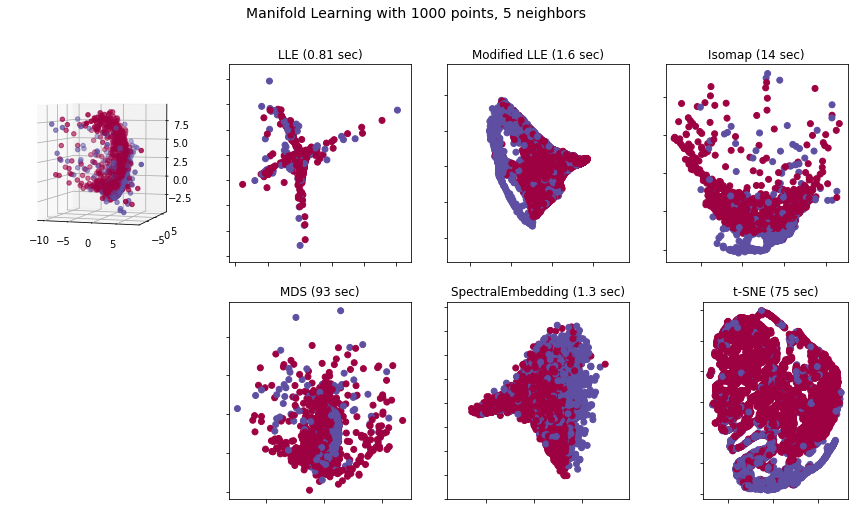

In [98]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8500:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 5
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

Automatically created module for IPython interactive environment
standard: 1.9 sec
modified: 3.3 sec
Isomap: 23 sec
MDS: 93 sec
SpectralEmbedding: 1.6 sec
t-SNE: 76 sec


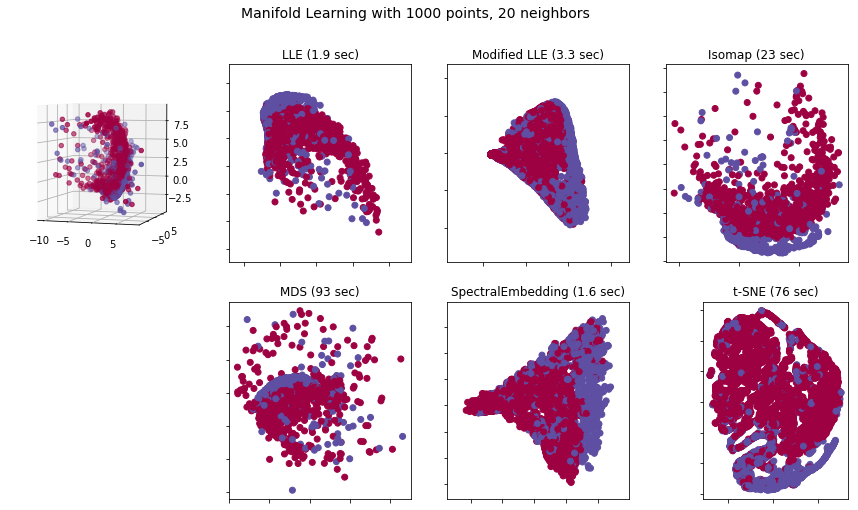

In [99]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8500:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 20
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### the results above show that the manifold learning algorithm themselves can not get satisfacting clustering result. Maybe the reason is under train or under-fitting

### Train the model for 10 more epochs

In [102]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=20,    
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 500 samples
Epoch 1/20
8000/8000 [==============================] - 11s - loss: -8072.0544 - val_loss: -7996.7534
Epoch 2/20
8000/8000 [==============================] - 11s - loss: -8096.5035 - val_loss: -8019.2729
Epoch 3/20
8000/8000 [==============================] - 11s - loss: -8087.3307 - val_loss: -8018.5586
Epoch 4/20
8000/8000 [==============================] - 11s - loss: -8066.5391 - val_loss: -8019.9268
Epoch 5/20
8000/8000 [==============================] - 11s - loss: -8070.8174 - val_loss: -8018.4237
Epoch 6/20
8000/8000 [==============================] - 11s - loss: -8089.1728 - val_loss: -8040.6006
Epoch 7/20
8000/8000 [==============================] - 11s - loss: -8100.3773 - val_loss: -8019.7527
Epoch 8/20
8000/8000 [==============================] - 11s - loss: -8097.6082 - val_loss: -8026.0383
Epoch 9/20
8000/8000 [==============================] - 11s - loss: -8096.1125 - val_loss: -8011.5261
Epoch 10/20
8000/8000 [============

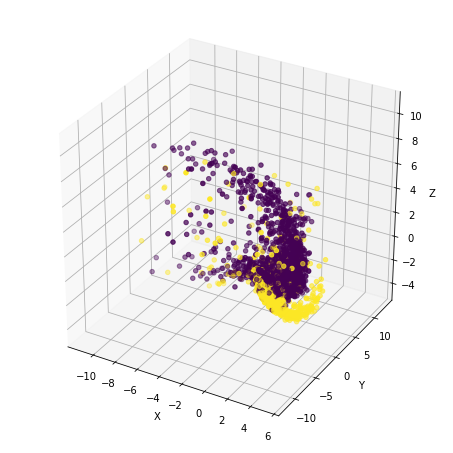

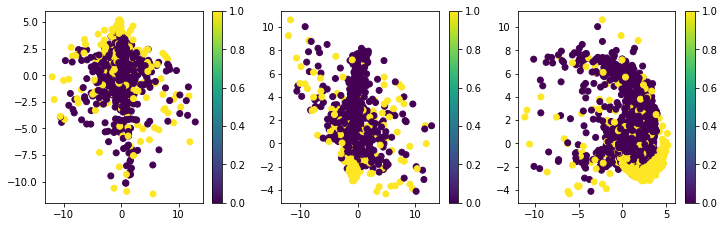

In [103]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(test_data, batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=label_value[8500:14000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000])
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 0.85 sec
modified: 1.7 sec
Isomap: 15 sec
MDS: 8.9 sec
SpectralEmbedding: 1.1 sec
t-SNE: 77 sec


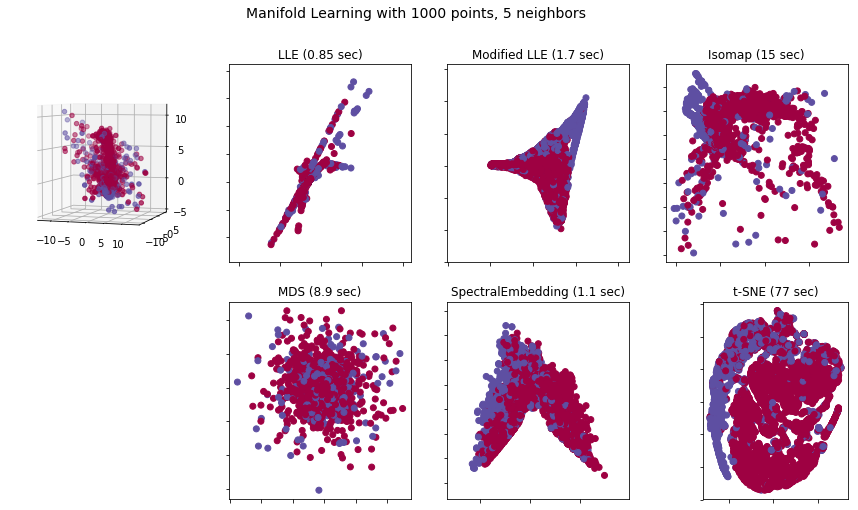

In [104]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8500:14000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 5
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

## Results
### I notice that there are only two dimensions in the hidden layer were activated. (or to say, only the Y-Z axis is useful). So, the next step is to test the performance with VAE has 2 hidden units.

## 2. with 2 hidden units

In [105]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,    
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

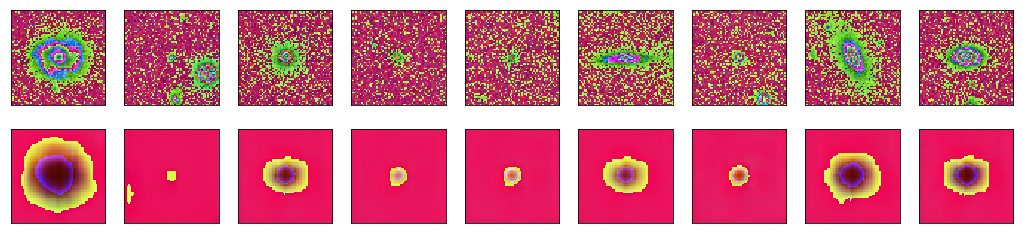

In [122]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[8000:9000],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

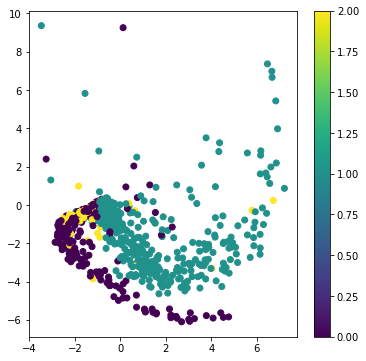

In [123]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 0.16 sec
modified: 0.26 sec
Isomap: 0.48 sec
MDS: 1.7 sec
SpectralEmbedding: 0.091 sec
t-SNE: 3.1 sec


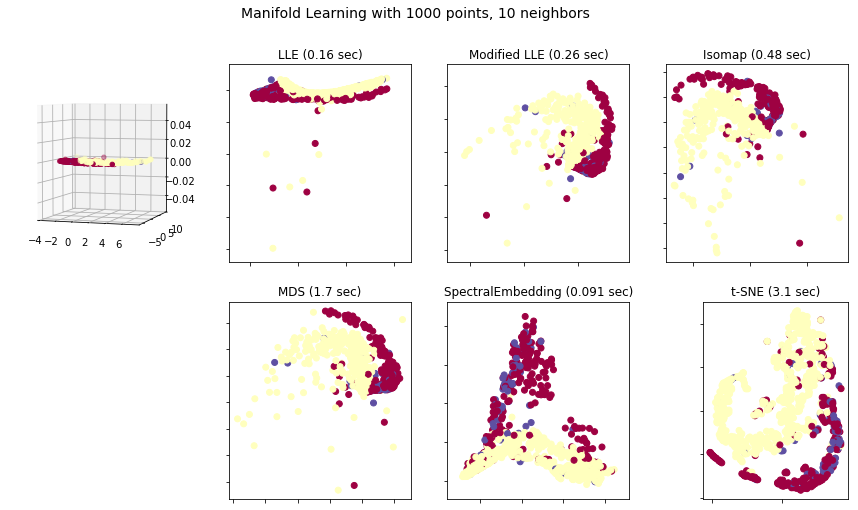

In [125]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:9000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()